In [1]:
from mlxtend.plotting import plot_decision_regions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
#ggplot is R based visualisation package that provides better graphics with higher level of abstraction

In [2]:
#Loading the dataset
test = pd.read_csv('../data/client_attrition_test_prep.csv')
train = pd.read_csv('../data/client_attrition_train_prep.csv')

# KNN

1. Split to target and explaining variables

I am going to choose the numer of k based on train split, where X is already defined and standardized an Y needs to be extracted from the train data base.

In [3]:
Y = train.account_status
X = train.drop(["customer_id"], axis=1)

In [4]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=1/3,random_state=42, stratify=Y)

In [5]:
X_train = X_train.drop(['account_status'], axis = 1)
X_test = X_test.drop(['account_status'], axis = 1)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1, 15):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train, Y_train)
    
    train_scores.append(knn.score(X_train, Y_train))
    test_scores.append(knn.score(X_test, Y_test))

max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100, list(map(lambda x: x+1, test_scores_ind))))


Max test score 86.78909952606635 % and k = [5]


In [7]:
train_scores

[1.0,
 0.9177899570434009,
 0.9197155976892313,
 0.8995704340097763,
 0.8998666864168271,
 0.890238483187676,
 0.8970522885498444,
 0.8883128425418456,
 0.8880165901347948,
 0.8825359206043549,
 0.8840171826396089,
 0.8779440082950674,
 0.8804621537549993,
 0.8763146200562879]

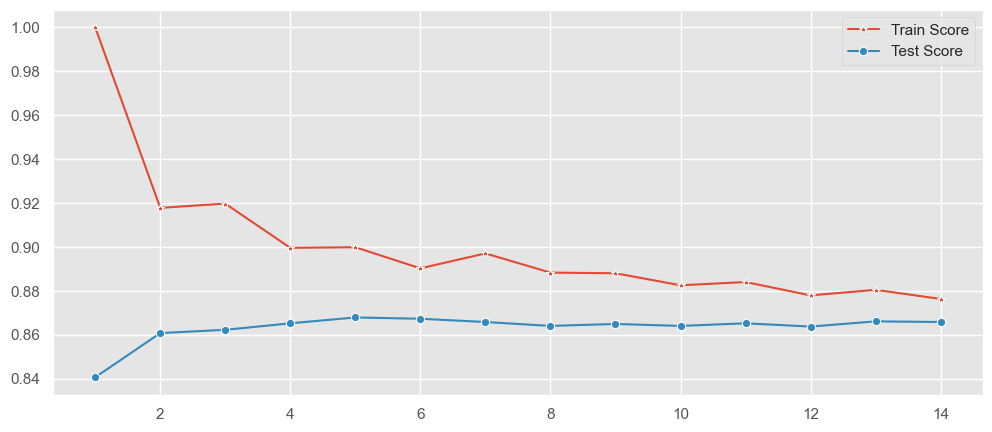

In [8]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')

The best score has been captured for k = 13

#
#
## Model training
train.fit trains the classifier and train.score calculates the accuracy. Importantly, the X_test and Y_test is the validation sample.

In [9]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(13)

knn.fit(X_train,Y_train)
knn.score(X_test,Y_test)

0.8661137440758294

# Model performance analysis

### 1. Confusion matrix

![](https://cdn-images-1.medium.com/max/1600/0*-GAP6jhtJvt7Bqiv.png)

In [10]:
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier (knn) we had fit above
Y_pred = knn.predict(X_test)
confusion_matrix(Y_test,Y_pred)
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,2729,105,2834
1,347,195,542
All,3076,300,3376


Text(0.5, 20.049999999999997, 'Predicted label')

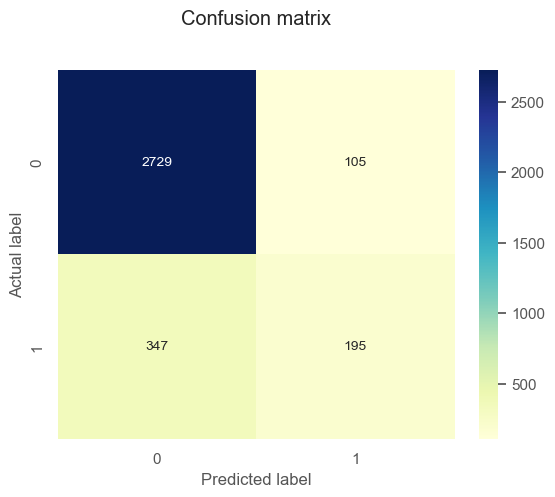

In [11]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Classification Report

In [12]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2834
           1       0.65      0.36      0.46       542

    accuracy                           0.87      3376
   macro avg       0.77      0.66      0.69      3376
weighted avg       0.85      0.87      0.85      3376



# ROC - AUC

In [13]:
from sklearn.metrics import roc_curve
Y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

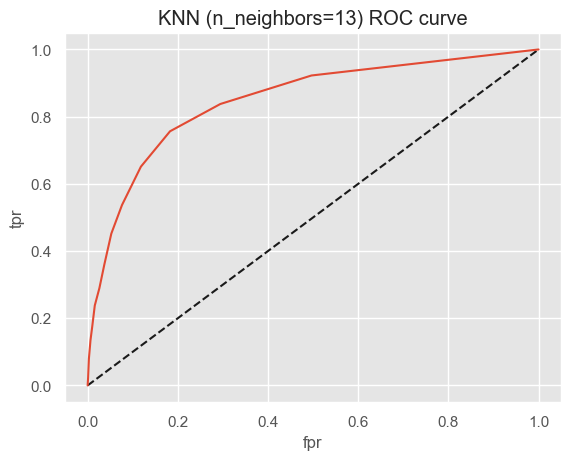

In [14]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('KNN (n_neighbors=13) ROC curve')
plt.show()

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, Y_pred_proba)

0.8477208748798849

A value of 0.88 might indicate a reasonably good performance of the model, as it is significantly better than random guessing. 

#

# Hyper parameter optimization

In [16]:
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,Y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.8689642548109149
Best Parameters: {'n_neighbors': 7}


In [17]:
#Setup a knn classifier with 15 neighbors
knn = KNeighborsClassifier(15)

knn.fit(X_train,Y_train)
knn.score(X_test,Y_test)

0.8675947867298578

In [18]:
#let us get the predictions using the classifier (knn) we had fit above
Y_pred_T = knn.predict(X_test)
confusion_matrix(Y_test,Y_pred_T)
pd.crosstab(Y_test, Y_pred_T, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,2734,100,2834
1,347,195,542
All,3081,295,3376


Text(0.5, 20.049999999999997, 'Predicted label')

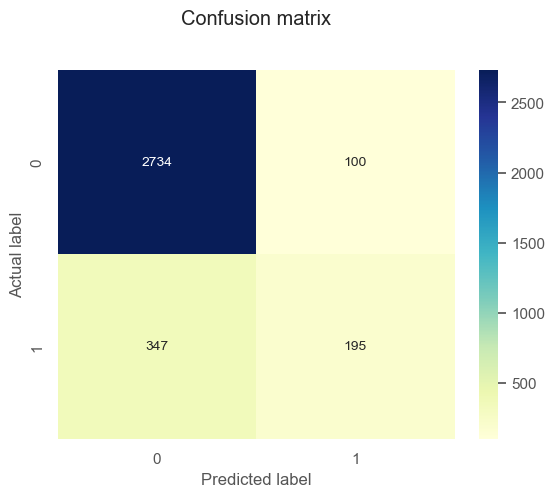

In [19]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_T)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [20]:
print(classification_report(Y_test,Y_pred_T))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2834
           1       0.66      0.36      0.47       542

    accuracy                           0.87      3376
   macro avg       0.77      0.66      0.70      3376
weighted avg       0.85      0.87      0.85      3376



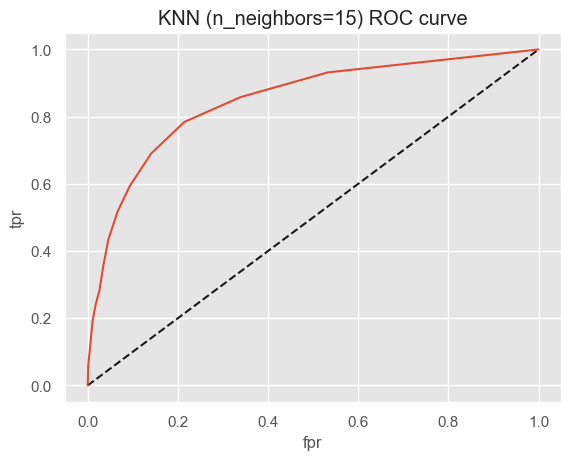

In [21]:
Y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('KNN (n_neighbors=15) ROC curve')
plt.show()

In [22]:
roc_auc_score(Y_test, Y_pred_proba)

0.8484021775644714

# Conclusion

In [23]:
test_knn = test.drop(['customer_id'], axis=1)

In [24]:
test_knn.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5063.0,2531.000000,1461.706537,0.000000,1265.500000,2531.000000,3796.500000,5062.000000
customer_age,5063.0,46.147738,7.169527,26.000000,41.000000,46.000000,51.000000,72.000000
customer_sex,5063.0,0.599052,0.490139,0.000000,0.000000,1.000000,1.000000,1.000000
customer_number_of_dependents,5063.0,1.951412,1.060595,0.000000,1.000000,2.000000,3.000000,5.000000
customer_education,5063.0,2.514715,0.927504,1.000000,2.000000,3.000000,3.000000,4.000000
customer_civil_status,5063.0,2.523800,0.551368,1.000000,2.000000,3.000000,3.000000,3.000000
customer_salary_range,5063.0,2.039305,1.290728,1.000000,1.000000,1.000000,3.000000,5.000000
customer_relationship_length,5063.0,35.593917,6.664137,13.000000,32.000000,36.000000,39.000000,55.000000
customer_available_credit_limit,5063.0,7381.328198,5693.059331,1449.000000,2935.043502,4987.448850,10411.841565,18825.100000
credit_card_classification,5063.0,1.006715,0.084064,1.000000,1.000000,1.000000,1.000000,3.000000


In [25]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,6751.0,5047.113020,2927.579583,0.0,2523.5000,5067.000,7584.000,10126.000
customer_age,6751.0,46.421715,8.499589,26.0,41.0000,46.000,52.000,73.000
customer_sex,6751.0,0.522145,0.499546,0.0,0.0000,1.000,1.000,1.000
customer_number_of_dependents,6751.0,2.350911,1.295902,0.0,1.0000,2.000,3.000,5.000
customer_education,6751.0,2.478448,0.996186,1.0,2.0000,3.000,3.000,4.000
customer_civil_status,6751.0,2.381573,0.656937,1.0,2.0000,2.000,3.000,3.000
customer_salary_range,6751.0,2.445415,1.372191,1.0,1.0000,2.000,4.000,5.000
customer_relationship_length,6751.0,35.818397,7.988059,13.0,31.0000,36.000,40.000,56.000
customer_available_credit_limit,6751.0,7575.851474,6183.214775,1449.0,2601.0000,4710.000,11960.500,18825.100
credit_card_classification,6751.0,1.083988,0.331412,1.0,1.0000,1.000,1.000,4.000


In [26]:
account_status_knn = knn.predict(test_knn)

In [27]:
test_knn['account_status_knn'] = account_status_knn

0    4726
1     337
Name: account_status_knn, dtype: int64


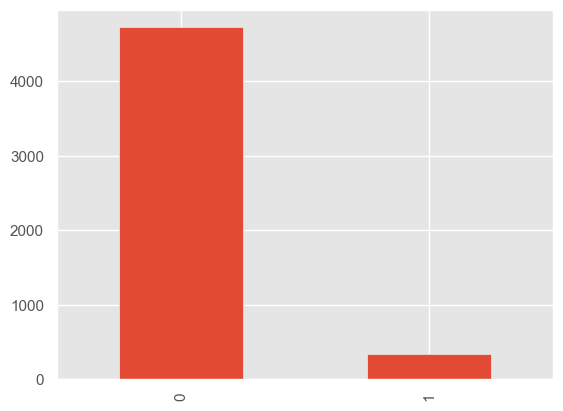

In [28]:
color_wheel = {1: "#0392cf", 
               2: "#7bc043"}
colors = test_knn["account_status_knn"].map(lambda x: color_wheel.get(x + 1))
print(test_knn.account_status_knn.value_counts())
p=test_knn.account_status_knn.value_counts().plot(kind="bar")

In [29]:
# view the percentage distribution of target_class column

test_knn['account_status_knn'].value_counts()/np.float(len(test))

0    0.933439
1    0.066561
Name: account_status_knn, dtype: float64

We observe high difference between svn and knn output, which leads us to the conclusion that svn might me overfitted. Let's compare the test and train databases.

In [30]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,10127.0,5063.000000,2923.557422,0.0,2531.500,5063.000,7594.500,10126.000
customer_id,10127.0,550508.987854,261237.656234,100069.0,323605.000,552548.000,777326.000,999911.000
customer_age,10127.0,46.473092,8.485400,26.0,41.000,46.000,52.000,73.000
customer_sex,10127.0,0.528883,0.499190,0.0,0.000,1.000,1.000,1.000
customer_number_of_dependents,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
customer_education,10127.0,2.483164,0.993703,1.0,2.000,3.000,3.000,4.000
customer_civil_status,10127.0,2.386393,0.660610,1.0,2.000,2.000,3.000,3.000
customer_salary_range,10127.0,2.452059,1.384306,1.0,1.000,2.000,4.000,5.000
customer_relationship_length,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
customer_available_credit_limit,10127.0,7529.661756,6176.547558,1449.0,2578.500,4696.000,11767.500,18825.100


In [31]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5063.0,2531.000000,1461.706537,0.000000,1265.500000,2531.000000,3796.500000,5062.000000
customer_id,5063.0,554624.784910,259753.736563,100163.000000,326746.500000,557332.000000,779934.000000,999857.000000
customer_age,5063.0,46.147738,7.169527,26.000000,41.000000,46.000000,51.000000,72.000000
customer_sex,5063.0,0.599052,0.490139,0.000000,0.000000,1.000000,1.000000,1.000000
customer_number_of_dependents,5063.0,1.951412,1.060595,0.000000,1.000000,2.000000,3.000000,5.000000
customer_education,5063.0,2.514715,0.927504,1.000000,2.000000,3.000000,3.000000,4.000000
customer_civil_status,5063.0,2.523800,0.551368,1.000000,2.000000,3.000000,3.000000,3.000000
customer_salary_range,5063.0,2.039305,1.290728,1.000000,1.000000,1.000000,3.000000,5.000000
customer_relationship_length,5063.0,35.593917,6.664137,13.000000,32.000000,36.000000,39.000000,55.000000
customer_available_credit_limit,5063.0,7381.328198,5693.059331,1449.000000,2935.043502,4987.448850,10411.841565,18825.100000


Looking at the distributions, test and train data seems to be comparable. Thus, the conclusion is svm model was overfitted and knn is most appropriate.

Final check

In [32]:
# view the percentage distribution of target_class column

test_knn['account_status_knn'].value_counts()/np.float(len(test))

0    0.933439
1    0.066561
Name: account_status_knn, dtype: float64

Correct, save to csv.

In [33]:
# Save the test database with predicted account_status to a CSV file
test_knn.to_csv('predicted_account_status.csv', index=False)

# Comments

Some of the columns in the script are commented for memory effectiveness. 